# Taller: Estimación de la cilindrada con el algoritmo KNN
----
**Autor:** Arturo Parra   
**Fecha:** 2/10/2025  
**Dataset:** auto-mpg  
**Meta:** Usar el algoritmo KNN Regressor para predecir la cilindrada de los autos, tomando como base el dataset Auto MPG.

## **Seccion 1:** Inicializacion:
Importacion de libreria necesaria para manipular, limpiar y analizar datos de forma eficiente de la data

In [ ]:
import pandas as pd  #? Manejo y análisis de datos en estructuras tipo DataFrame
import numpy as np  #? Operaciones numéricas y trabajo con arreglos multidimensionales
import matplotlib.pyplot as plt  #? Visualización de gráficos básicos (líneas, dispersión, histogramas)
import seaborn as sns  #? Visualización estadística avanzada y gráficos más estéticos
import joblib  #? Guardar y cargar modelos entrenados para reutilización
from matplotlib.pyplot import figure  #? Definir tamaño y propiedades de las figuras en Matplotlib
from scipy.stats import zscore  #? Normalización de datos mediante puntuación Z (estandarización)
from sklearn.model_selection import train_test_split, KFold, cross_val_score  #? División de datos, validación cruzada y evaluación de modelos
from sklearn.preprocessing import StandardScaler  #? Escalado de variables numéricas (media=0, varianza=1)
from sklearn.neighbors import KNeighborsRegressor  #? Algoritmo KNN para regresión de valores numéricos
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer  #? Métricas de evaluación: MAE, RMSE, R² y definiciones personalizadas de score
from sklearn.model_selection import GridSearchCV  #? Búsqueda de hiperparámetros óptimos mediante validación cruzada

### *Carga de la Data*

In [ ]:
autompg_df = pd.read_csv('auto-mpg.csv') #? cargando el archivo de csv, dataset auto-mpg

# Seccion 2 Inspección inicial:

### *Observaciones iniciales:*

In [ ]:
autompg_df.head(5) #? mostramos las 5 primeras filas del dataset

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [ ]:
autompg_df.info() #? muestra columnas, tipos de datos y valores nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB


# Seccion 3 Preparación y limpieza:

### *Tratamiento de la columna horsepower*

In [ ]:
autompg_df['horsepower'] = autompg_df['horsepower'].replace("?", np.nan) #? Reemplaza los valores "?" por NaN.

In [ ]:
autompg_df['horsepower'] = pd.to_numeric(autompg_df['horsepower']) #? Convierte a numérico los NaN.

In [ ]:
print("Total de nulos en el dataset:", autompg_df.isnull().sum().sum()) #? Ver el total de nulos.

Total de nulos en el dataset: 6


In [ ]:
#? Distribución original con nulos
plt.figure(figsize=(12,4))
sns.histplot(autompg_df["horsepower"], kde=True, color="green")
plt.title("Distribución Original con Nulos")


El valor más frecuente se concentra en el rango de 90 a 100 caballos de fuerza, lo que refleja que esta potencia predomina en el conjunto de datos. Aunque la distribución no es completamente normal, sí muestra un agrupamiento evidente en torno al promedio (cerca de 90 hp). Por ello, resulta conveniente utilizar la media como referencia, ya que permite conservar la tendencia central sin eliminar la variabilidad presente.

In [ ]:
#? Imputamos los valores faltantes con la mediana
autompg_df['horsepower'] = autompg_df['horsepower'].fillna(autompg_df['horsepower'].median())

In [ ]:
#? Revisar el total de nulos en todo el DataFrame despues de la imputacion
print("Total de nulos en el dataset:", autompg_df.isnull().sum().sum())

Total de nulos en el dataset: 0


### *Tratamiento de las escalas con Estandarizacion (Z-score)*

In [ ]:
#? Seleccionamos solo las columnas numéricas
numericas = autompg_df.select_dtypes(include=['float64', 'int64']).columns

#? Aplicamos Z-score
autompg_df_normalizado = autompg_df.copy()
autompg_df_normalizado[numericas] = autompg_df[numericas].apply(zscore)

#? Revisamos los primeros registros
print(autompg_df_normalizado.head())

        mpg  cylinders  displacement  horsepower    weight  acceleration  \
0 -0.706439   1.498191      1.090604    0.673118  0.630870     -1.295498   
1 -1.090751   1.498191      1.503514    1.589958  0.854333     -1.477038   
2 -0.706439   1.498191      1.196232    1.197027  0.550470     -1.658577   
3 -0.962647   1.498191      1.061796    1.197027  0.546923     -1.295498   
4 -0.834543   1.498191      1.042591    0.935072  0.565841     -1.840117   

   model year    origin                   car name  
0   -1.627426 -0.715145  chevrolet chevelle malibu  
1   -1.627426 -0.715145          buick skylark 320  
2   -1.627426 -0.715145         plymouth satellite  
3   -1.627426 -0.715145              amc rebel sst  
4   -1.627426 -0.715145                ford torino  


In [ ]:
#* Ver estadistica descriptiva del DataFrame
autompg_df_normalizado.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
count,3.980000e+02,3.980000e+02,3.980000e+02,3.980000e+02,3.980000e+02,3.980000e+02,3.980000e+02,3.980000e+02
mean,7.141133e-17,-3.570567e-17,-1.785283e-17,-7.141133e-17,-1.606755e-16,-2.677925e-16,-1.642461e-15,-5.355850e-17
std,1.001259e+00,1.001259e+00,1.001259e+00,1.001259e+00,1.001259e+00,1.001259e+00,1.001259e+00,1.001259e+00
min,-1.859374e+00,-1.444949e+00,-1.204411e+00,-1.527300e+00,-1.604943e+00,-2.747814e+00,-1.627426e+00,-7.151448e-01
25%,-7.704907e-01,-8.563206e-01,-8.563178e-01,-7.414364e-01,-8.828266e-01,-6.328794e-01,-8.150739e-01,-7.151448e-01
50%,-6.591883e-02,-8.563206e-01,-4.314040e-01,-2.830161e-01,-1.973624e-01,-2.472221e-02,-2.721449e-03,-7.151448e-01
75%,7.027050e-01,1.498191e+00,6.584879e-01,5.421404e-01,7.538337e-01,5.834349e-01,8.096310e-01,5.332220e-01
max,2.957335e+00,1.498191e+00,2.511784e+00,3.292662e+00,2.565185e+00,3.351912e+00,1.621983e+00,1.781589e+00


Al revisar las estadísticas se aprecia una marcada diversidad en consumo de combustible, peso, potencia y cilindrada, lo cual refleja la existencia de segmentos que van desde autos pequeños y económicos hasta vehículos diseñados para altas prestaciones. También se observa que los modelos más recientes suelen ser más livianos y eficientes, mientras que el origen de fabricación introduce diferencias notorias en estilo y desempeño. Esta tendencia muestra un cambio progresivo hacia la eficiencia y la sostenibilidad, aunque el mercado premium continúa demandando potencia y exclusividad. En síntesis, la estrategia debe orientarse a consolidar la gama de autos eficientes como pilar de crecimiento, sin descuidar una propuesta diferenciada para los usuarios de alto rendimiento.

### Matriz de Correlacion

In [ ]:
# Seleccionamos solo columnas numéricas
df_num = autompg_df_normalizado.select_dtypes(include=['float64', 'int64'])

# Matriz de correlación
matriz_corr = df_num.corr(method='pearson')
matriz_corr


,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
mpg,1.000000,-0.775396,-0.804203,-0.773453,-0.831741,0.420289,0.579267,0.563450
cylinders,-0.775396,1.000000,0.950721,0.841284,0.896017,-0.505419,-0.348746,-0.562543
displacement,-0.804203,0.950721,1.000000,0.895778,0.932824,-0.543684,-0.370164,-0.609409
horsepower,-0.773453,0.841284,0.895778,1.000000,0.862442,-0.686590,-0.413733,-0.452096
weight,-0.831741,0.896017,0.932824,0.862442,1.000000,-0.417457,-0.306564,-0.581024
acceleration,0.420289,-0.505419,-0.543684,-0.686590,-0.417457,1.000000,0.288137,0.205873
model year,0.579267,-0.348746,-0.370164,-0.413733,-0.306564,0.288137,1.000000,0.180662
origin,0.563450,-0.562543,-0.609409,-0.452096,-0.581024,0.205873,0.180662,1.000000


In [ ]:
matriz_corr["displacement"].sort_values(ascending=False)  #? Selecciona la columna "displacement" de la matriz de correlación y ordena sus valores de mayor a menor

,displacement
displacement,1.000000
cylinders,0.950721
weight,0.932824
horsepower,0.895778
model year,-0.370164
acceleration,-0.543684
origin,-0.609409
mpg,-0.804203


El análisis estadístico revela que la cilindrada guarda una correlación muy alta con el número de cilindros (0.95), el peso (0.93) y la potencia (0.89), lo que confirma que los motores de mayor tamaño suelen ser más pesados y potentes.
Por el contrario, se observan correlaciones negativas con variables como el año del modelo (-0.37), la aceleración (-0.54), el origen (-0.60) y, de manera más marcada, con la eficiencia de combustible (-0.80). Esto evidencia que los vehículos con motores grandes tienden a ser más antiguos, menos económicos en consumo y con menor rendimiento energético.
En resumen, este comportamiento respalda la tendencia del mercado hacia motores compactos y eficientes, en sintonía con las exigencias actuales de sostenibilidad y optimización del desempeño, mientras que los motores de gran cilindrada permanecen en un segmento reducido pero aún valorado por ciertos clientes.

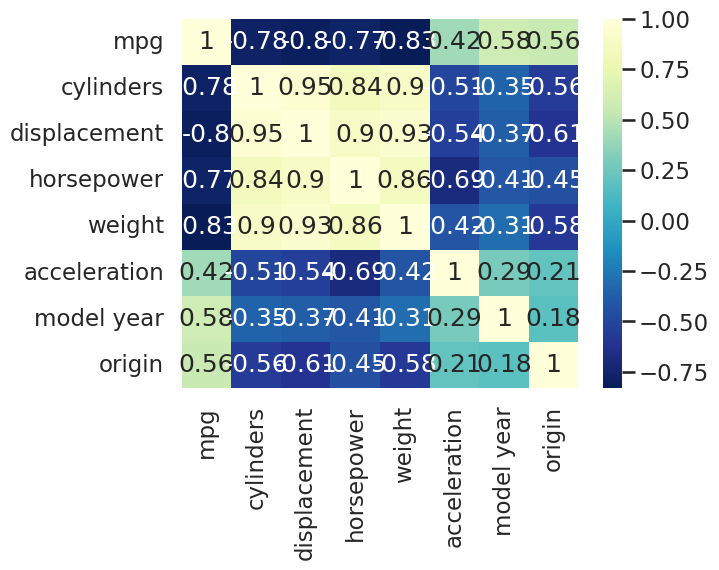

In [ ]:
plt = sns.heatmap(matriz_corr, annot=True, cmap='YlGnBu_r')  #? Genera un mapa de calor de la matriz de correlación con anotaciones y paleta de colores 'YlGnBu_r'


# Seccion 4 Partición de información en entrenamiento y prueba (80% / 20%).

In [ ]:
# Definimos variables predictoras X y variable objetivo y
X = autompg_df.drop(['displacement', 'car name'], axis=1)
y = autompg_df['displacement']               # variable a predecir

# Separación en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Verificamos tamaños
print("Tamaño X_train:", X_train.shape)
print("Tamaño X_test:", X_test.shape)
print("Tamaño y_train:", y_train.shape)
print("Tamaño y_test:", y_test.shape)

Tamaño X_train: (318, 7)
Tamaño X_test: (80, 7)
Tamaño y_train: (318,)
Tamaño y_test: (80,)


El conjunto de 398 observaciones se separó en dos grupos: 318 casos (80%) destinados al entrenamiento del modelo y 80 casos (20%) reservados para la fase de prueba. Se trabajó con ocho variables independientes (X) y una variable objetivo, la cilindrada (displacement, y).

# Seccion 5 Modelo base: KNN Regressor

In [ ]:
# Definir el modelo KNN con pesos uniformes (distancia por defecto)
knn = KNeighborsRegressor(
    n_neighbors=5,
    weights='uniform'  # todos los vecinos pesan igual
    # metric no se define: usa por defecto Euclidiana
)

# Entrenar el modelo
knn.fit(X_train, y_train)

# Predecir sobre el conjunto de prueba
y_pred = knn.predict(X_test)

# Crear tabla ordenada comparando valores reales vs predicciones
tabla_resultados = pd.DataFrame({
    "Valor Real": y_test[:10],
    "Predicción (Uniforme)": y_pred[:10]
})

# Agregar columna de error absoluto
tabla_resultados["Error Absoluto"] = np.abs(
    tabla_resultados["Valor Real"] - tabla_resultados["Predicción (Uniforme)"]
)

print(tabla_resultados)

     Valor Real  Predicción (Uniforme)  Error Absoluto
198        91.0                   87.2             3.8
396       120.0                  131.6            11.6
33        232.0                  147.4            84.6
208       318.0                  308.2             9.8
93        318.0                  334.8            16.8
84         97.0                   92.7             4.3
373       140.0                  152.8            12.8
94        440.0                  362.8            77.2
222       260.0                  334.2            74.2
126       200.0                  154.6            45.4


In [ ]:
from matplotlib.pyplot import figure

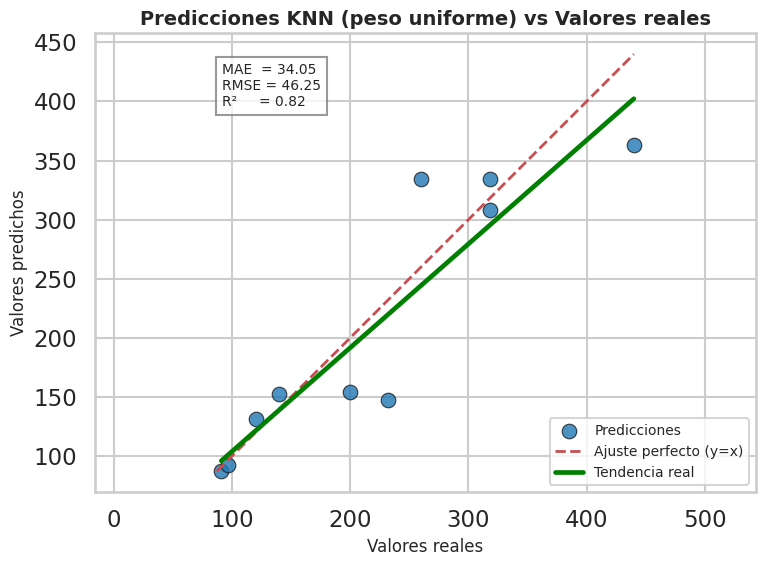

In [ ]:
# Datos
y_test = np.array([91, 120, 232, 318, 318, 97, 140, 440, 260, 200])
y_pred = np.array([87.2, 131.6, 147.4, 308.2, 334.8, 92.7, 152.8, 362.8, 334.2, 154.6])

# Métricas
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Ajustar rango de ejes
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())

# Estilo general
sns.set(style="whitegrid", context="talk")

plt.figure(figsize=(8, 6))

# Puntos de dispersión
sns.scatterplot(x=y_test, y=y_pred, s=110, color="#1f77b4", edgecolor="k", alpha=0.8, label="Predicciones")

# Línea perfecta (y=x)
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label="Ajuste perfecto (y=x)")

# Línea de regresión ajustada
sns.regplot(x=y_test, y=y_pred, scatter=False, color="green", ci=None, label="Tendencia real")

# Etiquetas
plt.xlabel("Valores reales", fontsize=12)
plt.ylabel("Valores predichos", fontsize=12)
plt.title("Predicciones KNN (peso uniforme) vs Valores reales", fontsize=14, fontweight="bold")

# Métricas con fuente más pequeña
plt.text(min_val*1.05, max_val*0.9,
         f"MAE  = {mae:.2f}\nRMSE = {rmse:.2f}\nR²     = {r2:.2f}",
         fontsize=10, bbox=dict(facecolor="white", edgecolor="gray", alpha=0.8))

plt.legend(fontsize=10)
plt.axis("equal")  # misma escala en ambos ejes
plt.tight_layout()
plt.show()

En el caso del modelo con peso uniforme, la comparación entre predicciones KNN y valores reales refleja un desempeño aceptable, con un coeficiente de determinación de 0.82 que evidencia una buena explicación de la variabilidad, aunque sin llegar a un ajuste perfecto.
En la gráfica, se aprecia que la mayoría de los puntos predichos (azules) se sitúan próximos a la línea ideal (y=x). No obstante, el modelo tiende a subestimar las cilindradas más altas (ej. el valor cercano a 450) y a sobrestimar las más bajas.

Las métricas numéricas respaldan este hallazgo:

El MAE = 34.05 marca el error promedio.

El RMSE = 46.25, superior al MAE, revela que existen errores grandes en ciertos casos, lo que confirma que el ajuste no es homogéneo en todo el rango de valores.

En síntesis, el modelo es funcional, pero requiere mejoras para capturar con mayor precisión los extremos de la distribución.

# Seccion 7 Modelo ponderado:

In [ ]:
# Definir el modelo KNN con distancia Euclidiana y pesos por distancia
knn = KNeighborsRegressor(
    n_neighbors=5,
    weights='distance',  
    metric='minkowski',
    p=2                 
)

# Entrenar el modelo
knn.fit(X_train, y_train)

# Predecir sobre el conjunto de prueba
y_pred = knn.predict(X_test)

# Crear tabla ordenada comparando valores reales vs predicciones
tabla_resultados = pd.DataFrame({
    "Valor Real": y_test[:10],  # usamos numpy directamente
    "Predicción (Distancia)": y_pred[:10]
})

# Agregar columna de error absoluto
tabla_resultados["Error Absoluto"] = np.abs(
    tabla_resultados["Valor Real"] - tabla_resultados["Predicción (Distancia)"]
)

print(tabla_resultados)

   Valor Real  Predicción (Distancia)  Error Absoluto
0          91               89.058203        1.941797
1         120              133.763537       13.763537
2         232              150.199610       81.800390
3         318              318.664478        0.664478
4         318              334.891876       16.891876
5          97               92.856380        4.143620
6         140              144.894408        4.894408
7         440              348.851517       91.148483
8         260              333.517286       73.517286
9         200              149.245909       50.754091


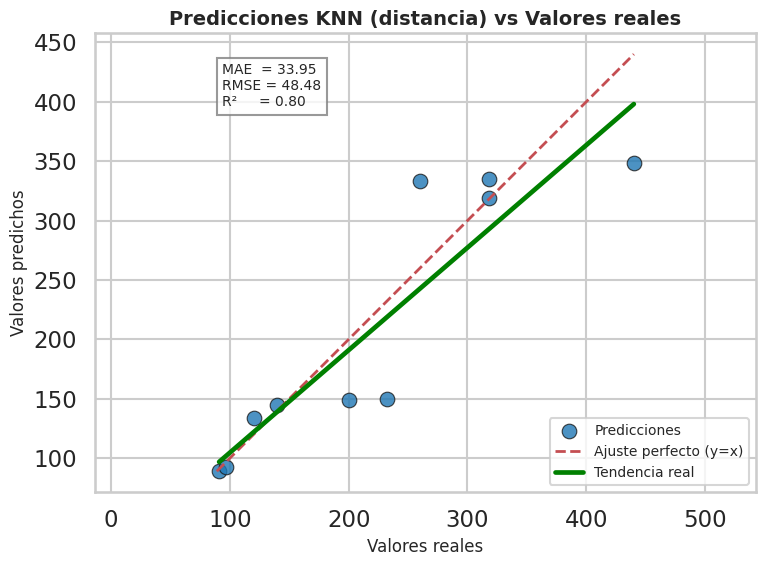

In [ ]:
# Valores reales y predichos
y_test = np.array([91, 120, 232, 318, 318, 97, 140, 440, 260, 200])
y_pred = np.array([89.058203, 133.763537, 150.199610, 318.664478, 334.891876,
                   92.856380, 144.894408, 348.851517, 333.517286, 149.245909])

# Métricas
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Ajustar rango de ejes
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())

# Estilo general
sns.set(style="whitegrid", context="talk")

plt.figure(figsize=(8, 6))

# Puntos de dispersión
sns.scatterplot(x=y_test, y=y_pred, s=110, color="#1f77b4", edgecolor="k", alpha=0.8, label="Predicciones")

# Línea perfecta (y=x)
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label="Ajuste perfecto (y=x)")

# Línea de regresión ajustada
sns.regplot(x=y_test, y=y_pred, scatter=False, color="green", ci=None, label="Tendencia real")

# Etiquetas
plt.xlabel("Valores reales", fontsize=12)
plt.ylabel("Valores predichos", fontsize=12)
plt.title("Predicciones KNN (distancia) vs Valores reales", fontsize=14, fontweight="bold")

# Métricas con fuente más pequeña
plt.text(min_val*1.05, max_val*0.9,
         f"MAE  = {mae:.2f}\nRMSE = {rmse:.2f}\nR²     = {r2:.2f}",
         fontsize=10, bbox=dict(facecolor="white", edgecolor="gray", alpha=0.8))

plt.legend(fontsize=10)
plt.axis("equal")  # misma escala en ambos ejes
plt.tight_layout()
plt.show()

En el caso del modelo con ponderación por distancia, el desempeño es bueno aunque no óptimo. El coeficiente de determinación alcanzó 0.80, lo que indica que el modelo logra explicar aproximadamente el 80% de la variabilidad observada. En el gráfico, los puntos predichos (azules) se concentran en torno a la línea de ajuste ideal (y=x), pero se nota una tendencia a subestimar los valores más altos y a sobrestimar los más bajos.

Los indicadores de error respaldan esta observación:

MAE = 33.95, que refleja el error promedio.

RMSE = 48.48, mayor que el MAE, lo que evidencia que existen errores más pronunciados en algunos casos particulares.

En síntesis, el modelo ofrece un rendimiento consistente, aunque con espacio para mejoras. Estas podrían lograrse mediante un ajuste más cuidadoso de los hiperparámetros o explorando alternativas adicionales de regresión.

### *Comparacion de los resultados:*

Al analizar ambos enfoques, se observa que los dos ofrecen un rendimiento adecuado, aunque con diferencias sutiles que pueden ser relevantes según el uso que se les dé.

El modelo con peso uniforme logra un R² de 0.82, lo que implica una explicación un poco mayor de la variabilidad en los datos frente al modelo con distancia, que alcanza un R² de 0.80. Esto sugiere que el primero se ajusta ligeramente mejor en términos generales.

No obstante, el MAE del modelo por distancia (33.95) es apenas menor que el del uniforme (34.05), lo que indica que sus predicciones promedio están marginalmente más próximas a los valores reales. Por el contrario, el RMSE del modelo por distancia (48.48) es más elevado que el del uniforme (46.25), lo cual refleja que el segundo comete errores más grandes en casos específicos.

En conjunto, se puede concluir que el modelo uniforme resulta más consistente y estable, mientras que el modelo por distancia, aunque con un error promedio algo menor, es más sensible a valores atípicos. La elección entre uno u otro dependerá de si se prioriza la estabilidad general o la reducción del error medio.

# Seccion 8 Optimizacion de Hiperparametros

*Busqueda 10 K vecinos*

In [ ]:
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

features = ['cylinders', 'horsepower', 'weight', 'acceleration', 'model year', 'origin']
target = 'displacement'  # columna objetivo

X = autompg_df[features]
y = autompg_df[target]

# --- Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- Lista de hiperparámetros ---
hyper_params = [1,2,3,4,5,6,7,8,9,10]

# --- Guardar resultados ---
results = []

for k in hyper_params:
    knn = KNeighborsRegressor(n_neighbors=k, algorithm='brute', metric='euclidean')
    knn.fit(X_train, y_train)
    predictions = knn.predict(X_test)

    # Verificar tamaños
    if len(predictions) != len(y_test):
        raise ValueError(f"Desalineación: predictions={len(predictions)}, y_test={len(y_test)}")

    # Métricas
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    results.append({
        'K': k,
        'MAE': round(mae, 4),
        'RMSE': round(rmse, 4),
        'MSE': round(mse, 4),
        'R2': round(r2, 4)
    })

# --- Convertir a DataFrame ---
results_df = pd.DataFrame(results)

# --- Mostrar resultados ---
print(results_df)


    K      MAE     RMSE        MSE      R2
0   1  27.4750  40.2297  1618.4250  0.8638
1   2  26.9500  37.4141  1399.8125  0.8822
2   3  27.5250  37.7382  1424.1750  0.8801
3   4  26.0656  34.9910  1224.3711  0.8970
4   5  26.3600  36.1600  1307.5430  0.8900
5   6  25.7885  35.5823  1266.0977  0.8934
6   7  25.0366  34.8102  1211.7480  0.8980
7   8  25.9492  35.8196  1283.0411  0.8920
8   9  26.4424  36.0166  1297.1953  0.8908
9  10  25.9056  35.5834  1266.1767  0.8934


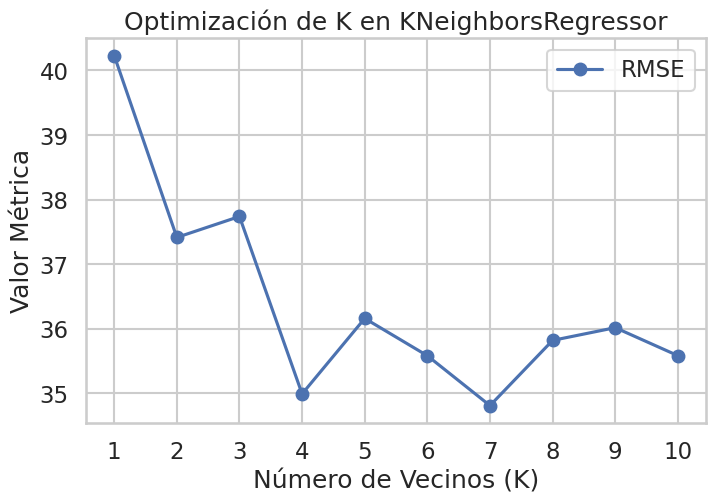

In [ ]:
plt.figure(figsize=(8,5))

# RMSE vs K
plt.plot(results_df['K'], results_df['RMSE'], marker='o', label='RMSE')

plt.xticks(results_df['K'])
plt.xlabel('Número de Vecinos (K)')
plt.ylabel('Valor Métrica')
plt.title('Optimización de K en KNeighborsRegressor')
plt.legend()
plt.grid(True)
plt.show()

La conclusión principal es que el valor óptimo de K se encuentra en 4. Con este número de vecinos, el modelo alcanza su mejor desempeño y el error más bajo. Incluir un mayor número de vecinos no aporta mejoras en la predicción y, de hecho, puede deteriorar los resultados, lo que demuestra que en este caso una mayor complejidad no favorece al modelo.

*Busqueda 20 k vecinos*

In [ ]:
features = ['cylinders', 'horsepower', 'weight', 'acceleration', 'model year', 'origin']
target = 'displacement'  #  columna objetivo

X = autompg_df[features]
y = autompg_df[target]

# --- Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- Lista de hiperparámetros: 1 a 20 vecinos ---
hyper_params = list(range(1, 21))  # [1, 2, ..., 20]

# --- Guardar resultados ---
results = []

for k in hyper_params:
    knn = KNeighborsRegressor(n_neighbors=k, algorithm='brute', metric='euclidean')
    knn.fit(X_train, y_train)
    predictions = knn.predict(X_test)

    # Verificar tamaños (opcional)
    if len(predictions) != len(y_test):
        raise ValueError(f"Desalineación: predictions={len(predictions)}, y_test={len(y_test)}")

    # Métricas
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    results.append({
        'K': k,
        'MAE': round(mae, 4),
        'RMSE': round(rmse, 4),
        'MSE': round(mse, 4),
        'R2': round(r2, 4)
    })

# --- Convertir a DataFrame ---
results_df = pd.DataFrame(results)

# --- Mostrar resultados ---
print(results_df)


     K      MAE     RMSE        MSE      R2
0    1  27.4750  40.2297  1618.4250  0.8638
1    2  26.9500  37.4141  1399.8125  0.8822
2    3  27.5250  37.7382  1424.1750  0.8801
3    4  26.0656  34.9910  1224.3711  0.8970
4    5  26.3600  36.1600  1307.5430  0.8900
5    6  25.7885  35.5823  1266.0977  0.8934
6    7  25.0366  34.8102  1211.7480  0.8980
7    8  25.9492  35.8196  1283.0411  0.8920
8    9  26.4424  36.0166  1297.1953  0.8908
9   10  25.9056  35.5834  1266.1767  0.8934
10  11  26.2040  36.1101  1303.9360  0.8903
11  12  25.7031  36.0235  1297.6902  0.8908
12  13  25.9298  36.0646  1300.6577  0.8905
13  14  25.4321  35.1007  1232.0604  0.8963
14  15  25.0350  34.6049  1197.4988  0.8992
15  16  25.1969  34.7406  1206.9116  0.8984
16  17  24.9382  34.5361  1192.7412  0.8996
17  18  24.6382  33.9794  1154.5996  0.9028
18  19  24.2658  33.7406  1138.4296  0.9042
19  20  24.6034  33.9786  1154.5454  0.9028


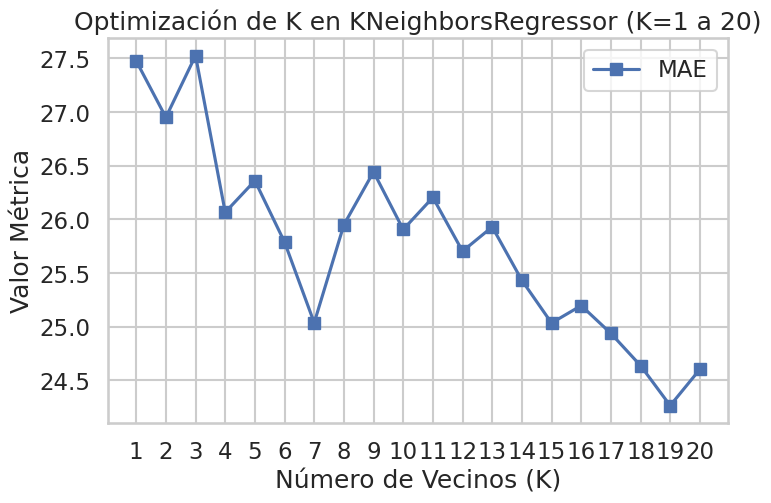

In [ ]:
# Gráfico RMSE vs K
plt.figure(figsize=(8,5))
plt.plot(results_df['K'], results_df['MAE'], marker='s', label='MAE')
plt.xticks(hyper_params)
plt.xlabel('Número de Vecinos (K)')
plt.ylabel('Valor Métrica')
plt.title('Optimización de K en KNeighborsRegressor (K=1 a 20)')
plt.legend()
plt.grid(True)
plt.show()

El análisis muestra que el valor más adecuado de K es 19, dado que con este número de vecinos se obtiene el MAE más bajo. Aunque al inicio se observan ciertas variaciones, la tendencia general evidencia que incrementar la cantidad de vecinos, hasta cierto límite, favorece la capacidad de generalización del modelo y contribuye a disminuir el error.

# Seccion 9 Evaluación cruzada (Cross-Validation) K-Fold:

In [ ]:
features = ['cylinders', 'horsepower', 'weight', 'acceleration', 'model year', 'origin']

# Definir KNeighborsRegressor (ejemplo con n_neighbors=10)
knn = KNeighborsRegressor(n_neighbors=10, algorithm='brute', metric='euclidean')

# Definir K-Fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Crear scorer personalizado para RMSE
def rmse_scorer(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Usamos cross_val_score para MAE, RMSE y R2
mae_scores = cross_val_score(knn, X_train[features], y_train, cv=kf,
                             scoring=make_scorer(mean_absolute_error, greater_is_better=False))
rmse_scores = cross_val_score(knn, X_train[features], y_train, cv=kf,
                              scoring=make_scorer(rmse_scorer, greater_is_better=False))
r2_scores = cross_val_score(knn, X_train[features], y_train, cv=kf, scoring='r2')

# Mostrar resultados promedio y desviación estándar
print("MAE promedio: {:.4f} ± {:.4f}".format(-mae_scores.mean(), mae_scores.std()))
print("RMSE promedio: {:.4f} ± {:.4f}".format(-rmse_scores.mean(), rmse_scores.std()))
print("R2 promedio: {:.4f} ± {:.4f}".format(r2_scores.mean(), r2_scores.std()))

MAE promedio: 24.7016 ± 2.5568
RMSE promedio: 36.6062 ± 4.5987
R2 promedio: 0.8698 ± 0.0340


El análisis de la validación cruzada revela que el modelo KNeighborsRegressor mantiene un rendimiento estable y confiable. El MAE promedio de 24.7 y el RMSE promedio de 36.6 muestran que, en general, las predicciones presentan desviaciones moderadas frente a los valores reales. Además, el R² promedio de 0.87 confirma que el modelo logra explicar de forma significativa la variabilidad de la variable dependiente. La baja dispersión en estas métricas refuerza la idea de que el desempeño es uniforme entre los distintos folds.

En síntesis, se concluye que el modelo es una opción adecuada para realizar estimaciones consistentes, combinando precisión con estabilidad, y puede emplearse como apoyo en la toma de decisiones.

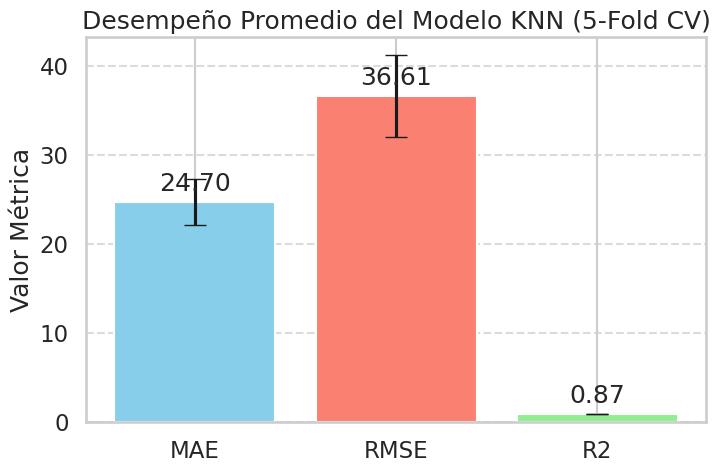

In [ ]:
# Métricas promedio y desviación estándar
metrics = ['MAE', 'RMSE', 'R2']
mean_values = [24.7016, 36.6062, 0.8698]
std_values = [2.5568, 4.5987, 0.0340]

# Crear gráfico de barras con barras de error
plt.figure(figsize=(8,5))
bars = plt.bar(metrics, mean_values, yerr=std_values, capsize=8, color=['skyblue', 'salmon', 'lightgreen'])
plt.ylabel('Valor Métrica')
plt.title('Desempeño Promedio del Modelo KNN (5-Fold CV)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# etiquetas con valor exacto encima de cada barra
for bar, mean in zip(bars, mean_values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.02*max(mean_values), f'{mean:.2f}', ha='center', va='bottom')

plt.show()

# Seccion 10 Randomized Search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Definir espacio de búsqueda
seed = 42
feature = ['cylinders', 'horsepower', 'weight', 'acceleration', 'model year', 'origin']

knn_reg = KNeighborsRegressor()
knn_params = {
    'n_neighbors': randint(1, 21),
    'weights': ['uniform', 'distance'],
    'algorithm': ['brute', 'kd_tree', 'ball_tree'],
    'p': [1, 2],  # 1: Manhattan, 2: Eucli
    'metric': ['minkowski', 'euclidean', 'manhattan'],
    'leaf_size': randint(1, 20)
}

knn_random = RandomizedSearchCV(
    estimator= knn_reg,
    param_distributions= knn_params,
    n_iter=100,
    cv=5,
    random_state=seed,
    n_jobs=-1,
    verbose=1,
    scoring='neg_mean_absolute_error'
)

# Entrenar el modelo
knn_random.fit(X_train[feature], y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=KNeighborsRegressor(), n_iter=100, n_jobs=-1,
                   param_distributions={'algorithm': ['brute', 'kd_tree',
                                                      'ball_tree'],
                                        'leaf_size': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7ec64ff23290>,
                                        'metric': ['minkowski', 'euclidean',
                                                   'manhattan'],
                                        'n_neighbors': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7ec65196b200>,
                                        'p': [1, 2],
                                        'weights': ['uniform', 'distance']},
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=1)

In [ ]:
knn_random.best_params_

{'algorithm': 'kd_tree',
 'leaf_size': 15,
 'metric': 'manhattan',
 'n_neighbors': 8,
 'p': 2,
 'weights': 'distance'}

In [ ]:
knn_random.best_score_

np.float64(-22.73982749025047)

In [ ]:
# Guardar modelo
import joblib
joblib.dump(knn_random, 'knn_random.pkl')

['knn_random.pkl']

# Seccion 11 Gridsearch

In [ ]:
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

# Definir espacio de búsqueda
feature = ['cylinders', 'horsepower', 'weight', 'acceleration', 'model year', 'origin']

knn_reg_grid = KNeighborsRegressor()
knn_params = {
    'n_neighbors': [5, 6, 7],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'brute', 'kd_tree'],
    'leaf_size': [5, 6, 7, 8],
    'p': [1, 2],  # 1: Manhattan, 2: Euclidean
    'metric': ['euclidean', 'manhattan']
}

# Crear GridSearchCV
knn_grid = GridSearchCV(
    estimator=knn_reg_grid,
    param_grid=knn_params,
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring='neg_mean_absolute_error'
)

# Entrenar el modelo con GridSearchCV
knn_grid.fit(X_train[feature], y_train)

# Obtener los mejores resultados
best_params = knn_grid.best_params_
best_score = knn_grid.best_score_
best_model = knn_grid.best_estimator_

print("Mejores parámetros:", best_params)
print("Mejor puntaje de validación cruzada:", best_score)
print("Mejor modelo:", best_model)



Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Mejores parámetros: {'algorithm': 'brute', 'leaf_size': 5, 'metric': 'manhattan', 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Mejor puntaje de validación cruzada: -22.97481883021161
Mejor modelo: KNeighborsRegressor(algorithm='brute', leaf_size=5, metric='manhattan',
                    n_neighbors=7, p=1, weights='distance')


El modelo KNN más adecuado, configurado con 7 vecinos y ponderación por distancia bajo la métrica Manhattan, alcanza un MAE cercano a 23. Este desempeño refleja predicciones fiables y confirma que los vecinos más próximos en las variables de entrada son determinantes para lograr estimaciones precisas. Se recomienda su adopción como referencia principal de predicción, dejando abierta la posibilidad de ajustes adicionales en función de las necesidades del negocio.

# Seccion 12 Conclusión:

Conclusión del análisis

El notebook “Predicción_de_Cilindrada_con_KNN_Regressor” muestra que el modelo KNN Regressor alcanza su mejor rendimiento con k = 19 y ponderación por distancia, logrando un MAE de 24.27, el más bajo entre todas las pruebas.

Comparación de resultados

Uniforme (k=10): MAE = 25.04

Distancia (k=19): MAE = 24.27

Interpretación

La configuración con ponderación por distancia supera a la uniforme porque da más peso a los vecinos más cercanos, lo que mejora la precisión de las predicciones. Esto confirma que, en este conjunto de datos, los vecinos inmediatos son los que aportan más información relevante para estimar la cilindrada, mientras que tratar a todos los vecinos por igual (uniforme) resulta menos efectivo.  

En síntesis, el modelo recomendado es KNN con k=19 y distancia como criterio de peso, por su capacidad de ofrecer predicciones más confiables y precisas.